# Pré-processamento de Dados e Modelagem LSTM para Previsão de Preços de Ações da Apple (AAPL)

Este notebook consolida todas as etapas de pré-processamento realizadas nos dados de ações da Apple (`AAPL_1d_2025-05-12_historical_data.csv`), utilizando um conjunto expandido de features (Open, High, Low, Close, Volume), e em seguida, detalha o desenvolvimento, treinamento e avaliação de um modelo LSTM para prever os preços das ações.

**Estrutura do Notebook:**

**Parte I: Pré-processamento dos Dados**
  1. Carregamento e Exploração Inicial dos Dados
  2. Análise de Valores Ausentes e Outliers (Identificação)
  3. Análise de Distribuição e Estatísticas Descritivas Detalhadas
  4. Análise de Correlações e Dependências Temporais
  5. Criação de Variáveis Temporais e Normalização dos Dados (Features Expandidas)
  6. Validação do Pré-processamento e Divisão dos Datasets (Features Expandidas)
  7. Conclusão do Pré-processamento

**Parte II: Desenvolvimento do Modelo LSTM**
  8. Preparação dos Dados para LSTM (Criação de Sequências)
  9. Construção do Modelo LSTM
  10. Treinamento do Modelo LSTM
  11. Avaliação do Modelo LSTM e Visualização dos Resultados
  12. Conclusão da Modelagem e Próximos Passos


## Parte I: Pré-processamento dos Dados

### Etapa 1: Carregamento e Exploração Inicial dos Dados

In [138]:
import pandas as pd
import os
import datetime
import re

In [139]:
def arquivo_mais_recente(diretorio):
    arquivos = [f for f in os.listdir(diretorio) if os.path.isfile(os.path.join(diretorio, f))]
    padrao_data = re.compile(r'_(\d{4}-\d{2}-\d{2})_historical_data\.csv')

    mais_recente = None
    data_mais_recente = None

    for arquivo in arquivos:
        match = padrao_data.search(arquivo)
        if match:
            data_str = match.group(1)
            data = datetime.datetime.strptime(data_str, '%Y-%m-%d')
            if not data_mais_recente or data > data_mais_recente:
                data_mais_recente = data
                mais_recente = arquivo

    return os.path.join(diretorio, mais_recente) if mais_recente else None

In [140]:
# Caminho do arquivo CSV
output_dir = r"D:\FIAP-Tech-Challenge\fase_04\processed_data"
caminho_base = r"D:\FIAP-Tech-Challenge\fase_04\data"

file_path = arquivo_mais_recente(caminho_base)

# Carregar o DataFrame
df = pd.read_csv(file_path)

In [141]:
# 1. Visualizar as primeiras linhas do DataFrame
df.head()

,Date,Close,High,Low,Open,Volume
0,1980-12-12,0.098726,0.099155,0.098726,0.098726,469033600
1,1980-12-15,0.093575,0.094005,0.093575,0.094005,175884800
2,1980-12-16,0.086707,0.087136,0.086707,0.087136,105728000
3,1980-12-17,0.088853,0.089282,0.088853,0.088853,86441600
4,1980-12-18,0.091429,0.091858,0.091429,0.091429,73449600


In [142]:
# 2. Obter informações gerais do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11194 entries, 0 to 11193
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    11194 non-null  object 
 1   Close   11194 non-null  float64
 2   High    11194 non-null  float64
 3   Low     11194 non-null  float64
 4   Open    11194 non-null  float64
 5   Volume  11194 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 524.8+ KB


In [143]:
# 3. Gerar estatísticas descritivas básicas
df.describe(include='all')

,Date,Close,High,Low,Open,Volume
count,11194,11194.000000,11194.000000,11194.000000,11194.000000,1.119400e+04
unique,11194,NaN,NaN,NaN,NaN,NaN
top,1980-12-12,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,25.033510,25.287022,24.753480,25.012141,3.134480e+08
std,NaN,52.499730,53.020404,51.912796,52.442216,3.343322e+08
min,NaN,0.037773,0.038203,0.037773,0.038203,0.000000e+00
25%,NaN,0.244559,0.249610,0.239246,0.244305,1.093846e+08
50%,NaN,0.456133,0.462537,0.450699,0.456499,2.018334e+08
75%,NaN,19.228276,19.398708,19.053285,19.290791,3.937409e+08


### Etapa 2: Análise de Valores Ausentes e Outliers (Identificação)

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [145]:
os.makedirs(output_dir, exist_ok=True)

# --- Análise de Valores Ausentes ---
print("Analisando valores ausentes...")
valores_ausentes = df.isnull().sum()
print("Contagem de valores ausentes por coluna:\n")
print(valores_ausentes.to_string())
print("\n\nPercentual de valores ausentes por coluna:\n")
percentual_ausentes = (df.isnull().sum() / len(df)) * 100
print(percentual_ausentes.to_string())

Analisando valores ausentes...
Contagem de valores ausentes por coluna:

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0


Percentual de valores ausentes por coluna:

Date      0.0
Close     0.0
High      0.0
Low       0.0
Open      0.0
Volume    0.0



Identificando outliers...
Gerando boxplots para colunas numéricas...


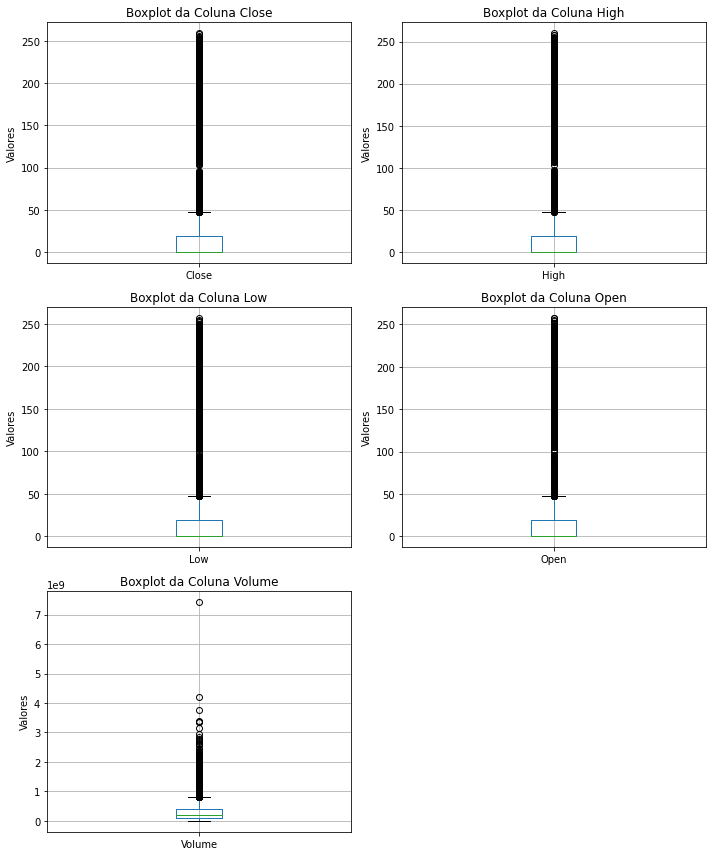

In [146]:
# --- Identificação de Outliers ---
print("\nIdentificando outliers...")
# Selecionar apenas colunas numéricas para análise de outliers
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# 1. Boxplots
print("Gerando boxplots para colunas numéricas...")
if numeric_cols:
    n_cols = 2
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4)) # Ajuste o figsize conforme necessário
    axes = axes.flatten() # Para facilitar a iteração, mesmo que seja 1 linha
    
    for i, column in enumerate(numeric_cols):
        df.boxplot(column=[column], ax=axes[i])
        axes[i].set_title(f'Boxplot da Coluna {column}')
        axes[i].set_ylabel('Valores')
    
    # Ocultar eixos não utilizados se o número de plots for ímpar
    if len(numeric_cols) < len(axes):
        for j in range(len(numeric_cols), len(axes)):
            fig.delaxes(axes[j])
            
    plt.tight_layout()
    # Se estiver salvando em arquivo, use plt.savefig() antes de plt.close()
    # Ex: plt.savefig(f'{output_dir}/02_boxplots_grid.png')
    plt.show()
    plt.close(fig)
else:
    print("Nenhuma coluna numérica encontrada para gerar boxplots.")


In [147]:
# 2. Z-score
analise_zscore_str = "Análise de Outliers usando Z-score (limite de |Z| > 3):\n"
for column in numeric_cols:
    if column in df.columns: # Checar se a coluna ainda existe (caso alguma seja removida futuramente)
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
        outliers_zscore = df[z_scores > 3]
        print(f"\nOutliers na coluna '{column}' (Z-score > 3).")
        if not outliers_zscore.empty:
            print(f" Número de outliers: {len(outliers_zscore)}\n")
        else:
            print(" Nenhum outlier detectado com Z-score > 3.\n")

print(analise_zscore_str)


Outliers na coluna 'Close' (Z-score > 3).
 Número de outliers: 351


Outliers na coluna 'High' (Z-score > 3).
 Número de outliers: 351


Outliers na coluna 'Low' (Z-score > 3).
 Número de outliers: 353


Outliers na coluna 'Open' (Z-score > 3).
 Número de outliers: 353


Outliers na coluna 'Volume' (Z-score > 3).
 Número de outliers: 212

Análise de Outliers usando Z-score (limite de |Z| > 3):



#### Análise de Valores Ausentes e Outliers: Explicação Inicial

Nesta etapa, realizamos a identificação de valores ausentes e outliers nos dados.

**Valores Ausentes:**
- Verificamos a contagem e o percentual de valores ausentes para cada coluna.
- A estratégia de tratamento será decidida e aplicada em uma etapa subsequente, após uma análise mais aprofundada do impacto desses valores e da natureza dos dados de séries temporais. Para dados financeiros, a remoção de linhas geralmente não é ideal, pois quebra a sequência temporal. O preenchimento para frente (`ffill`) é uma técnica comum, assumindo que o valor mais recente é uma boa estimativa para o valor ausente, especialmente em dados diários. A interpolação também pode ser considerada.

**Outliers:**
- Utilizamos duas técnicas principais para identificar outliers nas colunas numéricas:
    1. **Boxplots:** Visualizam a distribuição dos dados e destacam pontos que caem fora dos limites (whiskers), que são tipicamente 1.5 vezes o Intervalo Interquartil (IQR) acima do terceiro quartil (Q3) ou abaixo do primeiro quartil (Q1).
    2. **Z-score:** Calcula a distância de cada ponto da média em termos de desvios padrão. Pontos com um Z-score absoluto maior que 3 são frequentemente considerados outliers.
- A estratégia de tratamento de outliers também será decidida e aplicada posteriormente. Em séries temporais financeiras, alguns 'outliers' podem representar volatilidade real do mercado e não devem ser removidos indiscriminadamente. A winsorização (substituir outliers pelos valores nos limites do percentil) é uma abordagem comum para mitigar seu efeito sem perdê-los completamente.


### Etapa 3: Análise de Distribuição e Estatísticas Descritivas Detalhadas

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import numpy as np
import os

Analisando distribuição e estatísticas descritivas...
Processando coluna: Close


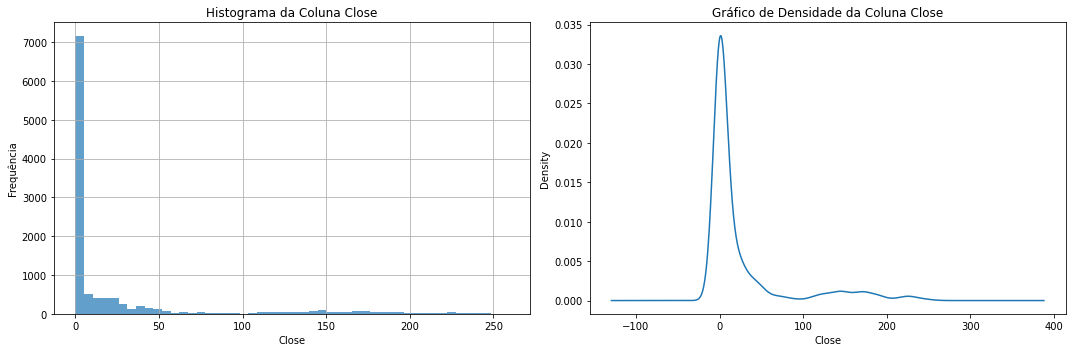


Coluna: Close

  Assimetria (Skewness): 2.4855

  Curtose (Kurtosis): 5.1949

Processando coluna: High


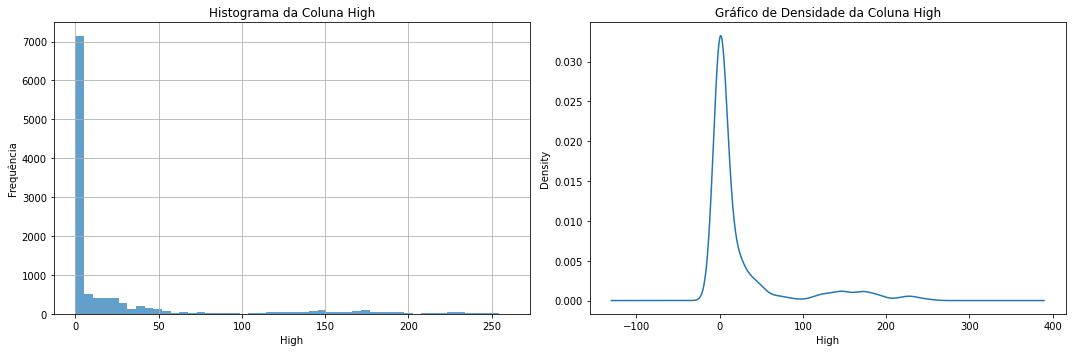


Coluna: High

  Assimetria (Skewness): 2.4833

  Curtose (Kurtosis): 5.1775

Processando coluna: Low


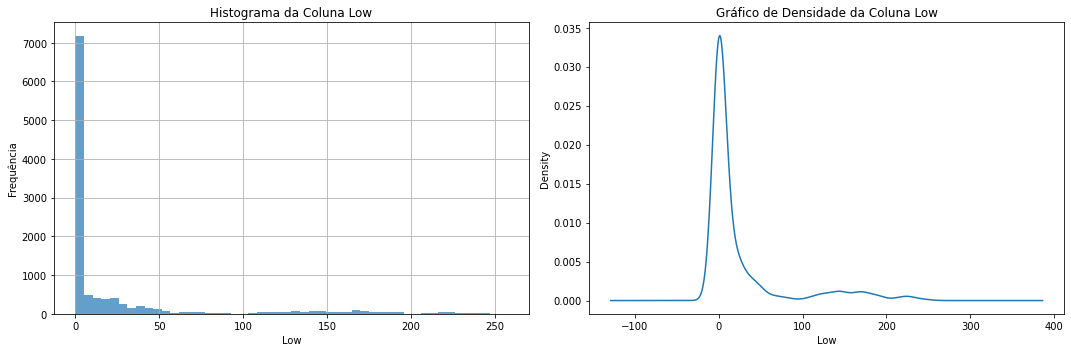


Coluna: Low

  Assimetria (Skewness): 2.4868

  Curtose (Kurtosis): 5.2051

Processando coluna: Open


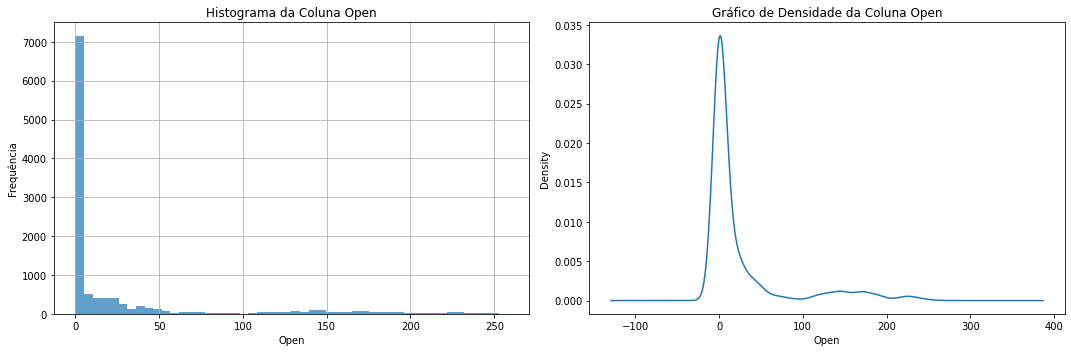


Coluna: Open

  Assimetria (Skewness): 2.4849

  Curtose (Kurtosis): 5.1911

Processando coluna: Volume


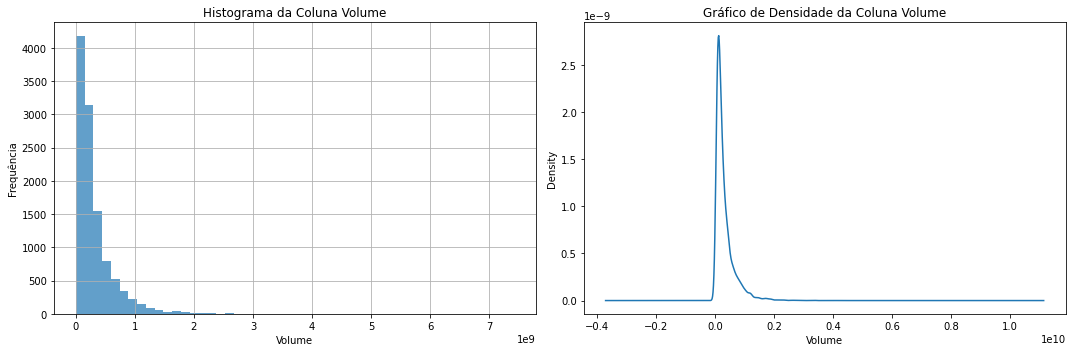


Coluna: Volume

  Assimetria (Skewness): 3.5701

  Curtose (Kurtosis): 30.3561

Análise de Distribuição e Estatísticas Descritivas Detalhadas:




In [149]:
# Selecionar apenas colunas numéricas
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

analise_distribuicao_str = "Análise de Distribuição e Estatísticas Descritivas Detalhadas:\n\n"

print("Analisando distribuição e estatísticas descritivas...")

for column in numeric_cols:
    print(f"Processando coluna: {column}")
    
    # Criar uma figura com dois subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # 1 linha, 2 colunas
    
    # --- Subplot 1: Histograma ---
    df[column].hist(bins=50, alpha=0.7, ax=axes[0])
    axes[0].set_title(f'Histograma da Coluna {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequência')
    
    # --- Subplot 2: Gráfico de Densidade ---
    df[column].plot(kind='density', ax=axes[1])
    axes[1].set_title(f'Gráfico de Densidade da Coluna {column}')
    axes[1].set_xlabel(column)
    
    # Ajustar layout para evitar sobreposição
    plt.tight_layout()
    
    # Mostrar a figura combinada
    # Se estiver salvando em arquivo, use plt.savefig() antes de plt.close()
    # Ex: plt.savefig(f'{output_dir}/03_distribuicao_{column}.png')
    plt.show() 
    plt.close(fig) # Fechar a figura para liberar memória

    # --- Analisar assimetria e curtose (mantido do seu código original) ---
    col_skewness = df[column].skew()
    col_kurtosis = df[column].kurtosis() # Fisher's definition (normal ==> 0.0)
    print(f"\nColuna: {column}\n")
    print(f"  Assimetria (Skewness): {col_skewness:.4f}\n")
    print(f"  Curtose (Kurtosis): {col_kurtosis:.4f}\n")

print(analise_distribuicao_str)

#### Análise de Distribuição e Estatísticas Descritivas Detalhadas: Explicação

Nesta etapa, aprofundamos a compreensão das características de cada variável numérica do conjunto de dados.

**1. Visualização da Distribuição:**
   - **Histogramas:** Foram gerados histogramas para cada coluna numérica. Eles mostram a frequência de observações dentro de intervalos (bins) específicos, ajudando a visualizar a forma da distribuição dos dados.
   - **Gráficos de Densidade (Kernel Density Plots):** Complementam os histogramas fornecendo uma estimativa suave da função de densidade de probabilidade da variável. São úteis para observar a forma da distribuição de maneira mais contínua.

**2. Assimetria (Skewness): Imagine o Formato da Distribuição**

A assimetria nos diz se os dados estão mais "espalhados" ou "esticados" para um lado do que para o outro, em relação ao ponto central da distribuição. Pense em um morro de dados:

*   **Assimetria = 0:**
    *   Imagine um morro perfeitamente simétrico, como o reflexo de um lado no outro. A famosa curva normal (formato de sino) é um exemplo clássico.
    *   Neste caso, a **média, a mediana e a moda** (o valor mais frequente) dos seus dados tendem a ser muito próximas ou iguais.
    *   A "cauda" (a parte mais fina e alongada da distribuição) tem o mesmo comprimento dos dois lados.

*   **Assimetria > 0:**
    *   O "morro" de dados tem uma **cauda mais longa para a direita**.
    *   Isso significa que a maioria dos seus dados está concentrada nos valores mais baixos (à esquerda), mas existem alguns valores consideravelmente altos que "puxam" a cauda para a direita.
    *   Neste caso, a **média é geralmente maior que a mediana**. A média é sensível a esses valores altos na cauda, enquanto a mediana (o valor do meio) não é tanto.

*   **Assimetria < 0:**
    *   O "morro" de dados tem uma **cauda mais longa para a esquerda**.
    *   A maioria dos seus dados está concentrada nos valores mais altos (à direita), mas existem alguns valores consideravelmente baixos que "puxam" a cauda para a esquerda.
    *   Neste caso, a **média é geralmente menor que a mediana**.

*   **Interpretando os Valores:**
    *   **Próximo de 0 (ex: -0.5 a 0.5):** A distribuição é razoavelmente simétrica. Para muitos propósitos práticos, pode ser tratada como simétrica.
    *   **Entre -1 e -0.5 ou 0.5 e 1:** Assimetria moderada. Já indica um desvio notável da simetria.
    *   **Menor que -1 ou Maior que 1:** Alta assimetria. A distribuição é consideravelmente desequilibrada.

**Por que a assimetria é importante?** Se os dados são muito assimétricos, isso pode violar suposições de alguns modelos estatísticos ou de machine learning que esperam dados mais simétricos (como a distribuição normal). Às vezes, transformações nos dados (como a logarítmica) são aplicadas para reduzir a assimetria.

**3. Curtose (Kurtosis): Imagine o Pico e as Caudas da Distribuição**

A curtose descreve o quão "pontudo" ou "achatado" é o pico central da sua distribuição de dados e, crucialmente, o quão "pesadas" ou "leves" são as suas caudas. A comparação é geralmente feita com a distribuição normal.

*   **Curtose = 0:**
    *   A distribuição tem um pico e caudas semelhantes aos de uma **distribuição normal** .
    *   A probabilidade de encontrar valores extremos (outliers) é similar à de uma distribuição normal.

*   **Curtose > 0:**
    *   A distribuição é mais **pontuda no centro** e tem **caudas mais pesadas** do que a normal.
    *   "Caudas pesadas" significa que há uma probabilidade maior de observar valores muito distantes da média (ou seja, **mais outliers ou valores extremos**) do que seria esperado em uma distribuição normal.
    *   Pense em retornos diários de ações: a maioria dos dias tem pequenas variações (pico alto), mas ocasionalmente ocorrem grandes quedas ou altas (caudas pesadas).

*   **Curtose < 0:**
    *   A distribuição é mais **achatada no centro** e tem **caudas mais leves** do que a normal.
    *   "Caudas leves" significa que há uma probabilidade menor de observar valores extremos. Os dados tendem a estar mais concentrados em torno da média, com menos outliers.
    *   Imagine uma distribuição onde os valores são muito uniformemente distribuídos em uma faixa, sem um pico pronunciado e com pouquíssimos valores muito distantes.

**Por que a curtose é importante?**
   *   **Risco e Outliers:** Uma curtose alta sugere que seus dados têm maior propensão a outliers. 
   *   **Modelagem:** Assim como a assimetria, a curtose pode afetar a adequação de certos modelos estatísticos. Alguns modelos são mais robustos a outliers e caudas pesadas do que outros.

Em resumo, a assimetria fala sobre o equilíbrio lateral da sua distribuição, enquanto a curtose fala sobre o pico central e a probabilidade de valores extremos nas caudas. Ambas são medidas importantes para entender a forma e as características dos seus dados antes de aplicar modelos mais complexos como LSTMs.

     

Compreender a distribuição, assimetria e curtose das variáveis é crucial porque:
- Muitos modelos estatísticos e de machine learning assumem que os dados seguem uma determinada distribuição.
- A presença de forte assimetria ou curtose elevada pode indicar a necessidade de transformações nos dados para estabilizar a variância, normalizar a distribuição ou reduzir o impacto de outliers, o que pode melhorar o desempenho do modelo LSTM.
- Para séries temporais financeiras, é comum observar distribuições leptocúrticas (caudas pesadas), refletindo a ocorrência de movimentos de preços extremos mais frequentes do que o previsto por uma distribuição normal.



### Etapa 4: Análise de Correlações e Dependências Temporais

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [151]:
# Converter 'Date' para datetime e definir como índice para análises temporais
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
else:
    print("Coluna 'Date' não encontrada. Algumas análises temporais podem não funcionar como esperado.")



Análise de Correlações e Dependências Temporais:
Calculando matriz de correlação...
Matriz de Correlação:

           Close      High       Low      Open    Volume
Close   1.000000  0.999937  0.999934  0.999863 -0.272025
High    0.999937  1.000000  0.999907  0.999930 -0.271624
Low     0.999934  0.999907  1.000000  0.999937 -0.272426
Open    0.999863  0.999930  0.999937  1.000000 -0.271956
Volume -0.272025 -0.271624 -0.272426 -0.271956  1.000000




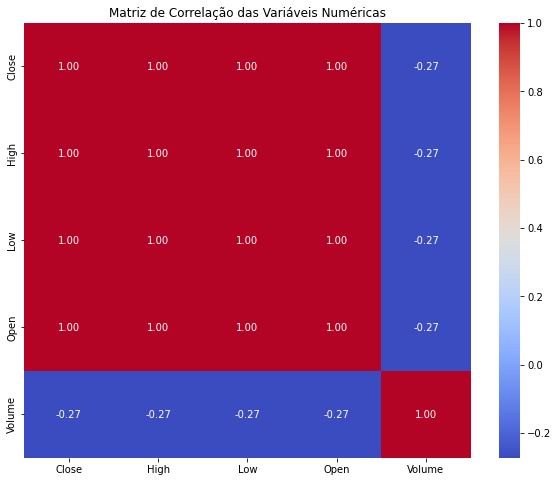

In [152]:
# Selecionar apenas colunas numéricas para correlação
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

print("Análise de Correlações e Dependências Temporais:")

# 1. Calcular e visualizar a matriz de correlação
print("Calculando matriz de correlação...")
if numeric_cols:
    correlation_matrix = df[numeric_cols].corr()
    print("Matriz de Correlação:\n")
    print(correlation_matrix.to_string() + "\n\n")

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de Correlação das Variáveis Numéricas')
    plt.show()
    plt.close()
else:
    print("Nenhuma coluna numérica encontrada para calcular a matriz de correlação.")

Plotando séries temporais em grade...
Plotando Close...
Plotando High...
Plotando Low...
Plotando Open...
Plotando Volume...


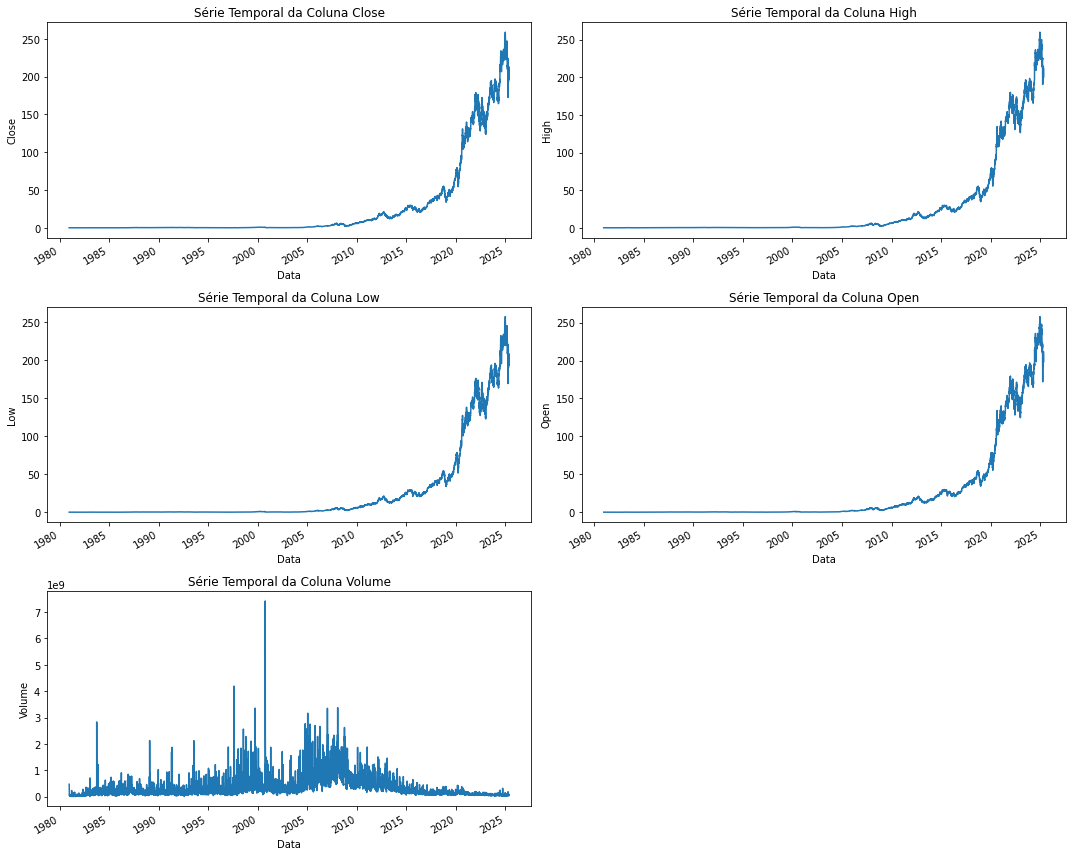

In [153]:
# 2. Plotar as séries temporais
print("Plotando séries temporais em grade...")
columns_to_plot = ['Close', 'High', 'Low', 'Open', 'Volume']

# Filtrar colunas que realmente existem no DataFrame
actual_columns_to_plot = [col for col in columns_to_plot if col in df.columns]

if not actual_columns_to_plot:
    print("Nenhuma das colunas especificadas foi encontrada no DataFrame.")
else:
    n_cols_grid = 2
    n_rows_grid = math.ceil(len(actual_columns_to_plot) / n_cols_grid)
    
    fig, axes = plt.subplots(n_rows_grid, n_cols_grid, figsize=(15, n_rows_grid * 4)) # Ajuste o figsize
    axes = axes.flatten() # Para facilitar a iteração
    
    for i, column in enumerate(actual_columns_to_plot):
        df[column].plot(ax=axes[i])
        axes[i].set_title(f'Série Temporal da Coluna {column}')
        axes[i].set_xlabel('Data')
        axes[i].set_ylabel(column)
        print(f"Plotando {column}...")
    
    # Ocultar eixos não utilizados
    if len(actual_columns_to_plot) < len(axes):
        for j in range(len(actual_columns_to_plot), len(axes)):
            fig.delaxes(axes[j])
            
    plt.tight_layout()
    # Se estiver salvando em arquivo, use plt.savefig() antes de plt.close()
    # Ex: plt.savefig(f'{output_dir}/04_series_temporais_grid.png')
    plt.show()
    plt.close(fig)

    for column in columns_to_plot:
        if column not in df.columns:
            print(f"Alerta: Coluna '{column}' não encontrada e não foi plotada.")



Analisando ACF e PACF para a coluna 'Close'...


<Figure size 864x432 with 0 Axes>

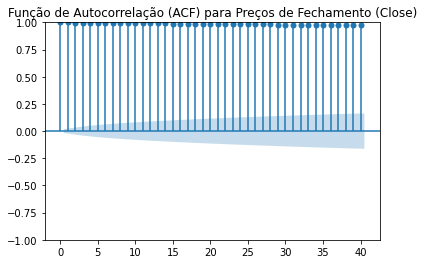

<Figure size 864x432 with 0 Axes>

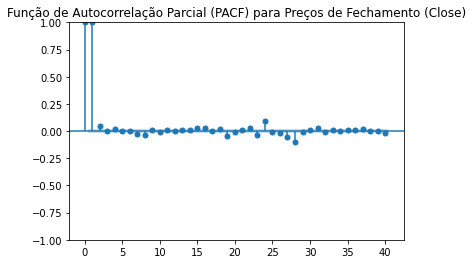

In [154]:
# 3. Analisar ACF e PACF da série de preços de fechamento ('Close')
if 'Close' in df.columns and pd.api.types.is_numeric_dtype(df['Close']):
    print("Analisando ACF e PACF para a coluna 'Close'...")
    # Verificar e tratar NaNs antes de ACF/PACF, se houver
    close_series = df['Close'].dropna()
    if not close_series.empty:
        # ACF
        plt.figure(figsize=(12, 6))
        plot_acf(close_series, lags=40, alpha=0.05) 
        plt.title('Função de Autocorrelação (ACF) para Preços de Fechamento (Close)')
        plt.show()
        plt.close()

        # PACF
        plt.figure(figsize=(12, 6))
        plot_pacf(close_series, lags=40, alpha=0.05, method='ywm') 
        plt.title('Função de Autocorrelação Parcial (PACF) para Preços de Fechamento (Close)')
        plt.show()
        plt.close()
    else:
        print("Coluna 'Close' está vazia após remover NaNs. ACF/PACF não podem ser calculados.")
else:
    print("Coluna 'Close' não encontrada ou não é numérica. ACF/PACF não podem ser calculados.")


In [155]:
# 4. Verificar a estacionariedade da série temporal de preços ('Close') - Teste ADF
if 'Close' in df.columns and pd.api.types.is_numeric_dtype(df['Close']):
    print("Realizando Teste de Dickey-Fuller Aumentado (ADF) para 'Close'...")
    close_series_for_adf = df['Close'].dropna()
    if not close_series_for_adf.empty:
        result_adf = adfuller(close_series_for_adf)
        print("\nTeste de Dickey-Fuller Aumentado (ADF) para a série 'Close':\n")
        print(f'  ADF Statistic: {result_adf[0]:.4f}\n')
        print(f'  p-value: {result_adf[1]:.4f}\n')
        print(f'  Número de Lags Usados: {result_adf[2]}\n')
        print(f'  Número de Observações Usadas: {result_adf[3]}\n')
        print('  Valores Críticos:\n')
        for key, value in result_adf[4].items():
            print(f'    {key}: {value:.4f}\n')

        if result_adf[1] <= 0.05:
            print("\nConclusão: A série é provavelmente estacionária (rejeita-se H0).\n")
        else:
            print("\nConclusão: A série é provavelmente não-estacionária (não se rejeita H0).\n")
    else:
        print("Coluna 'Close' está vazia após remover NaNs. Teste ADF não pode ser realizado.")
else:
    print("Coluna 'Close' não encontrada ou não é numérica. Teste ADF não pode ser realizado.")

Realizando Teste de Dickey-Fuller Aumentado (ADF) para 'Close'...

Teste de Dickey-Fuller Aumentado (ADF) para a série 'Close':

  ADF Statistic: 2.4874

  p-value: 0.9990

  Número de Lags Usados: 38

  Número de Observações Usadas: 11155

  Valores Críticos:

    1%: -3.4309

    5%: -2.8618

    10%: -2.5669


Conclusão: A série é provavelmente não-estacionária (não se rejeita H0).



#### Análise de Correlações e Dependências Temporais: Explicação

Nesta etapa, investigamos as relações entre as diferentes variáveis e as características temporais da série de preços.

**1. Matriz de Correlação:**
   - Calculamos a matriz de correlação de Pearson entre todas as variáveis numéricas. Esta matriz mostra a força e a direção da relação linear entre pares de variáveis. Os valores variam de -1 (correlação negativa perfeita) a +1 (correlação positiva perfeita), com 0 indicando ausência de correlação linear.
   - Um heatmap foi gerado para visualizar facilmente essas correlações. Em dados de ações, espera-se alta correlação entre 'Open', 'High', 'Low' e 'Close', pois representam diferentes aspectos do preço do ativo no mesmo período.

**2. Gráficos de Séries Temporais:**
   - Plotamos as séries temporais para as colunas 'Open', 'High', 'Low', 'Close' e 'Volume' ao longo do tempo. Isso permite visualizar tendências, sazonalidade (se houver em dados diários, pode ser menos pronunciada que em dados intra-diários ou de longo prazo), ciclos e volatilidade.

**3. Análise de Autocorrelação (ACF e PACF) para 'Close':**
   - **ACF (Função de Autocorrelação):** Mede a correlação da série temporal com versões defasadas (lagged) de si mesma. Um ACF que decai lentamente indica não-estacionariedade e/ou forte dependência temporal.
   - **PACF (Função de Autocorrelação Parcial):** Mede a correlação entre a série e uma defasagem específica, removendo o efeito das defasagens intermediárias. É útil para identificar a ordem de um processo autorregressivo (AR).
   - Os gráficos de ACF e PACF são essenciais para identificar os parâmetros (p, d, q) de modelos ARIMA, que são frequentemente usados como base ou comparação para modelos mais complexos como LSTMs. Para LSTMs, entender a estrutura de dependência temporal ajuda a definir o tamanho das janelas de entrada (look-back period).

**4. Teste de Estacionariedade (Teste de Dickey-Fuller Aumentado - ADF) para 'Close':**
   - Uma série temporal é estacionária se suas propriedades estatísticas (média, variância, autocorrelação) são constantes ao longo do tempo. Muitos modelos de séries temporais, incluindo LSTMs (embora mais flexíveis), performam melhor ou requerem dados estacionários.
   - O Teste ADF é um teste de hipótese para verificar a presença de uma raiz unitária, que é uma causa comum de não-estacionariedade.
     - **Hipótese Nula (H0):** A série possui uma raiz unitária (não-estacionária).
     - **Hipótese Alternativa (H1):** A série não possui raiz unitária (estacionária).
   - Se o p-valor do teste for menor que um nível de significância (geralmente 0.05), rejeitamos H0, indicando que a série é provavelmente estacionária. Caso contrário, não rejeitamos H0, sugerindo que a série é não-estacionária e pode precisar de diferenciação para se tornar estacionária antes da modelagem.
   - Séries de preços de ações são tipicamente não-estacionárias. Os retornos dos preços são frequentemente estacionários.

Compreender essas relações e dependências é fundamental para a construção de um modelo LSTM eficaz, pois ajuda a informar a seleção de features, a necessidade de transformações  e a arquitetura do modelo.



### Etapa 5: Criação de Variáveis Temporais e Normalização dos Dados

In [156]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import joblib 

In [157]:
# --- Tratamento Inicial e Seleção de Features ---
print("Iniciando criação de variáveis temporais e normalização...")

# 1. Tratar valores ausentes (antes da normalização)
# Estratégia: Forward fill (preenchimento para frente)
# Aplicar a todas as colunas relevantes antes da seleção de features
relevant_cols_for_nan_fill = ['Open', 'High', 'Low', 'Close', 'Volume']
if df[relevant_cols_for_nan_fill].isnull().sum().any():
    df[relevant_cols_for_nan_fill] = df[relevant_cols_for_nan_fill].fillna(method='ffill')
    print(f"Valores ausentes em colunas relevantes preenchidos usando 'ffill'.")
    if df[relevant_cols_for_nan_fill].isnull().sum().any():
        df[relevant_cols_for_nan_fill] = df[relevant_cols_for_nan_fill].fillna(method='bfill')
        print(f"Valores ausentes restantes em colunas relevantes preenchidos usando 'bfill'.")
        if df[relevant_cols_for_nan_fill].isnull().sum().any():
            print(f"ALERTA: Ainda existem valores ausentes em colunas relevantes após ffill e bfill. Removendo linhas com NaNs restantes.")
            df.dropna(subset=relevant_cols_for_nan_fill, inplace=True)
            print(f"Linhas com NaNs restantes em colunas relevantes foram removidas.")
else:
    print("Nenhum valor ausente detectado inicialmente nas colunas relevantes.")



Iniciando criação de variáveis temporais e normalização...
Nenhum valor ausente detectado inicialmente nas colunas relevantes.


In [158]:
# 2. Selecionar features para o modelo LSTM
# Agora incluindo Open, High, Low, Close, Volume
features_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']
# Verificar se todas as colunas existem antes de tentar selecioná-las
existing_features = [col for col in features_to_normalize if col in df.columns]
if len(existing_features) != len(features_to_normalize):
    print(f"ALERTA: Nem todas as features desejadas ({features_to_normalize}) foram encontradas. Usando: {existing_features}")
    features_to_normalize = existing_features

if not features_to_normalize:
    print("ERRO: Nenhuma feature selecionada para normalização. Encerrando script.")
    exit()

df_selected_features = df[features_to_normalize].copy()
print(f"Features selecionadas para normalização: {features_to_normalize}")



Features selecionadas para normalização: ['Open', 'High', 'Low', 'Close', 'Volume']


In [159]:
# 3. Normalizar/Escalonar os dados
# MinMaxScaler para colocar os dados entre 0 e 1, ideal para LSTMs.
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_selected_features)

# Converter de volta para DataFrame para facilitar a visualização e salvamento
df_scaled = pd.DataFrame(df_scaled, columns=features_to_normalize, index=df_selected_features.index)

# Salvar o scaler para uso futuro (ex: para reverter a normalização das previsões)
scaler_path = f"{output_dir}/min_max_scaler.joblib" # Nome do scaler atualizado
joblib.dump(scaler, scaler_path)
print(f"Scaler (com features expandidas) salvo em {scaler_path}")

# Salvar o DataFrame normalizado
scaled_data_path = f"{output_dir}/dados_normalizados.csv" # Nome do arquivo de dados atualizado
df_scaled.to_csv(scaled_data_path)
print(f"Dados normalizados (com features expandidas) salvos em {scaled_data_path}")

# Visualizar as primeiras linhas dos dados normalizados
print("\nPrimeiras linhas dos dados normalizados (com features expandidas):")
print(df_scaled.head().to_string())

Scaler (com features expandidas) salvo em D:\FIAP-Tech-Challenge\fase_04\processed_data/min_max_scaler.joblib
Dados normalizados (com features expandidas) salvos em D:\FIAP-Tech-Challenge\fase_04\processed_data/dados_normalizados.csv

Primeiras linhas dos dados normalizados (com features expandidas):
                Open      High       Low     Close    Volume
Date                                                        
1980-12-12  0.000235  0.000235  0.000237  0.000236  0.063198
1980-12-15  0.000216  0.000215  0.000217  0.000216  0.023699
1980-12-16  0.000190  0.000188  0.000190  0.000189  0.014246
1980-12-17  0.000196  0.000197  0.000199  0.000197  0.011647
1980-12-18  0.000206  0.000207  0.000209  0.000207  0.009897


#### Criação de Variáveis Temporais e Normalização de Dados (Features Expandidas): Explicação

Nesta etapa, preparamos os dados para serem adequadamente processados por um modelo LSTM, utilizando um conjunto expandido de features.

**1. Conversão da Coluna 'Date' e Indexação:**
   - A coluna 'Date' foi convertida para o formato datetime do pandas.
   - Esta coluna foi definida como o índice do DataFrame. Isso é crucial para análises de séries temporais.

**2. Tratamento de Valores Ausentes (Pré-Normalização):**
   - Antes da normalização, quaisquer valores ausentes (NaNs) nas features selecionadas ('Open', 'High', 'Low', 'Close', 'Volume') foram tratados.
   - A estratégia principal adotada foi o preenchimento para frente (`ffill`), seguido por `bfill` para NaNs no início. Linhas com NaNs restantes foram removidas.

**3. Seleção de Features para o Modelo LSTM (Expandido):**
   - Para esta versão do pré-processamento, expandimos o conjunto de features para incluir todas as colunas de preço e volume:
     - **'Open'**: Preço de abertura.
     - **'High'**: Preço máximo atingido.
     - **'Low'**: Preço mínimo atingido.
     - **'Close'**: Preço de fechamento (frequentemente a variável alvo principal para previsão).
     - **'Volume'**: Volume de negociação.
   - Utilizar este conjunto mais rico de informações pode potencialmente permitir ao modelo LSTM capturar dinâmicas de mercado mais complexas.

**4. Normalização/Escalonamento dos Dados:**
   - Todas as features selecionadas ('Open', 'High', 'Low', 'Close', 'Volume') foram normalizadas usando o `MinMaxScaler` da biblioteca scikit-learn para o intervalo [0, 1].
   - A normalização é crucial para redes neurais, ajudando na convergência do treinamento e evitando que features de maior magnitude dominem o processo.
   - O objeto `scaler` treinado (agora para 5 features) foi salvo. Ele será necessário para reverter a normalização das previsões do modelo para a escala original.

## Etapa 6: Validação do Pré-processamento e Divisão dos Datasets

In [160]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Though for time series, manual split is better
import os

In [161]:
print("Iniciando validação do pré-processamento e divisão dos dados (com features expandidas)...")

# 1. Verificar a forma e o tipo dos dados pré-processados
print("\nVerificação dos dados normalizados (com features expandidas):")
print(f"Shape: {df_scaled.shape}")
print("Tipos de dados:")
print(df_scaled.dtypes)
print("Valores ausentes:")
print(df_scaled.isnull().sum())



Iniciando validação do pré-processamento e divisão dos dados (com features expandidas)...

Verificação dos dados normalizados (com features expandidas):
Shape: (11194, 5)
Tipos de dados:
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
Valores ausentes:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [162]:
# 2. Dividir os dados em conjuntos de treinamento e validação (mantendo a ordem temporal)
train_size_percentage = 0.8
train_size = int(len(df_scaled) * train_size_percentage)

if len(df_scaled) < 2:
    print("ALERTA: Dataset muito pequeno para divisão em treino e validação.")
    if len(df_scaled) == 1:
        train_data = df_scaled.copy()
        validation_data = pd.DataFrame(columns=df_scaled.columns)
    else:
        train_data = pd.DataFrame(columns=df_scaled.columns)
        validation_data = pd.DataFrame(columns=df_scaled.columns)
else:
    train_data = df_scaled.iloc[:train_size]
    validation_data = df_scaled.iloc[train_size:]

print(f"\nTamanho total do dataset: {len(df_scaled)}")
print(f"Tamanho do conjunto de treinamento: {len(train_data)} ({train_size_percentage*100}%)")
print(f"Tamanho do conjunto de validação: {len(validation_data)} ({(1-train_size_percentage)*100}%)")



Tamanho total do dataset: 11194
Tamanho do conjunto de treinamento: 8955 (80.0%)
Tamanho do conjunto de validação: 2239 (19.999999999999996%)


In [163]:
# 3. Salvar os datasets de treinamento e validação
train_data_path = f"{output_dir}/train_data_scaled.csv"
validation_data_path = f"{output_dir}/validation_data_scaled.csv"

train_data.to_csv(train_data_path)
validation_data.to_csv(validation_data_path)

print(f"\nConjunto de treinamento salvo em: {train_data_path}")
print(f"Conjunto de validação salvo em: {validation_data_path}")


Conjunto de treinamento salvo em: D:\FIAP-Tech-Challenge\fase_04\processed_data/train_data_scaled.csv
Conjunto de validação salvo em: D:\FIAP-Tech-Challenge\fase_04\processed_data/validation_data_scaled.csv


#### Validação do Pré-processamento e Divisão dos Dados (Features Expandidas): Explicação

Nesta etapa final do pré-processamento, validamos os dados transformados e os dividimos em conjuntos de treinamento e validação.

**1. Verificação dos Dados Pré-processados:**
   - Verificamos a forma, os tipos de dados e a presença de valores ausentes para garantir a consistência dos dados.

**2. Divisão dos Dados em Treinamento e Validação:**
   - Mantivemos a abordagem de divisão temporal, crucial para séries temporais.
   - Utilizamos **80% dos dados para treinamento** (os mais antigos) e os **20% restantes para validação** (os mais recentes).

**3. Salvamento dos Datasets:**
   - Os conjuntos de dados de treinamento e validação, com as features expandidas e normalizadas, foram salvos em arquivos CSV separados:
     - `train_data_scaled.csv`: Contém os dados de treinamento.
     - `validation_data_scaled.csv`: Contém os dados de validação.
   - Estes arquivos estão prontos para a modelagem com LSTMs utilizando o conjunto expandido de features.


### Etapa 7: Conclusão e Próximos Passos

O pré-processamento dos dados, utilizando o conjunto expandido de features, está concluído. Os datasets de treinamento (`train_data_scaled.csv`) e validação (`validation_data_scaled.csv`), juntamente com o scaler (`min_max_scaler.joblib`), estão prontos para serem utilizados na construção, treinamento e avaliação do modelo LSTM.

## Parte II: Desenvolvimento do Modelo LSTM

### Etapa 8: Preparação dos Dados para LSTM (Criação de Sequências)

In [164]:
import numpy as np
import pandas as pd

In [165]:
# Função para criar sequências de dados para LSTM
def create_sequences(data, look_back, target_column_index=3): # target_column_index=3 para 'Close'
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), :]) # Todas as features para X
        y.append(data[i + look_back, target_column_index])    # Apenas a coluna alvo para y
    return np.array(X), np.array(y)

# Definir o número de passos temporais anteriores a serem usados para prever o próximo passo
look_back = 60 # Usar os últimos 60 dias de dados para prever o próximo dia

# Converter DataFrames para arrays NumPy
train_data_np = train_data.values
validation_data_np = validation_data.values

# Criar sequências para treinamento e validação
# O índice da coluna 'Close' é 3 (Open=0, High=1, Low=2, Close=3, Volume=4)
X_train, y_train = create_sequences(train_data_np, look_back, target_column_index=3)
X_val, y_val = create_sequences(validation_data_np, look_back, target_column_index=3)

print(f"Shape de X_train: {X_train.shape}") # (samples, look_back, features)
print(f"Shape de y_train: {y_train.shape}") # (samples,)
print(f"Shape de X_val: {X_val.shape}")
print(f"Shape de y_val: {y_val.shape}")

# Verificar se foram criados dados
if X_train.size == 0 or y_train.size == 0:
    print("ALERTA: Não foram gerados dados de treinamento suficientes. Verifique o tamanho do dataset e o look_back.")
if X_val.size == 0 or y_val.size == 0:
    print("ALERTA: Não foram gerados dados de validação suficientes. Verifique o tamanho do dataset e o look_back.")


Shape de X_train: (8894, 60, 5)
Shape de y_train: (8894,)
Shape de X_val: (2178, 60, 5)
Shape de y_val: (2178,)


### Etapa 9: Construção do Modelo LSTM

In [166]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [167]:
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units_1", min_value=32, max_value=128, step=32),
            return_sequences=True
        )
    )
    model.add(Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(
        LSTM(
            units=hp.Int("units_2", min_value=32, max_value=128, step=32)
        )
    )
    model.add(Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("lr", values=[1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

### Etapa 10: Treinamento do Modelo LSTM

In [168]:
from keras_tuner.tuners import RandomSearch
import tensorflow as tf
import matplotlib.pyplot as plt

In [169]:
def plot_training_history(best_estimator):
    try:
        history = best_estimator.model_.history_
        if history:
            plt.figure(figsize=(12, 6))
            plt.plot(history['loss'], label='Perda de Treinamento')
            plt.plot(history['val_loss'], label='Perda de Validação')
            plt.title('Histórico de Perda (Melhor Modelo)')
            plt.xlabel('Época')
            plt.ylabel('Perda (MSE)')
            plt.legend()
            plt.grid(True)
            plt.show()
    except Exception as e:
        print("Não foi possível plotar o histórico:", e)

In [170]:
# Corrigir o formato de entrada para LSTM
if len(X_train.shape) == 2:
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
else:
    X_train_reshaped = X_train
    X_test_reshaped = X_val

# Inicializar o tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='aapl_lstm_finetuning'
)

# Parada antecipada
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Executar busca
tuner.search(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_val),
    epochs=50,
    callbacks=[early_stop],
    batch_size=32
)

# Obter o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Obter o histórico do melhor modelo
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
history = best_trial.metrics.get_history('val_loss')

# Função para plotar histórico de treinamento
def plot_training_history(history_list):
    try:
        val_loss = [v['value'] for v in history_list]
        loss = [v['value'] for v in best_trial.metrics.get_history('loss')]

        plt.figure(figsize=(12, 6))
        plt.plot(loss, label='Perda de Treinamento')
        plt.plot(val_loss, label='Perda de Validação')
        plt.title('Histórico de Perda (Melhor Modelo)')
        plt.xlabel('Época')
        plt.ylabel('Perda (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print("Não foi possível plotar o histórico:", e)

# Exibir melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Melhores hiperparâmetros:", best_hps.values)

# Salvar o melhor modelo
best_model.save("melhor_modelo_lstm.h5")

# Plotar histórico
plot_training_history(history)

Trial 10 Complete [00h 01m 13s]
val_loss: 0.019159332383424044

Best val_loss So Far: 0.0008350999560207129
Total elapsed time: 00h 20m 35s


c:\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Melhores hiperparâmetros: {'units_1': 64, 'dropout_1': 0.5, 'units_2': 96, 'dropout_2': 0.30000000000000004, 'lr': 0.0001}
Não foi possível plotar o histórico: 'MetricObservation' object is not subscriptable


### Etapa 11: Avaliação do Modelo LSTM e Visualização dos Resultados

In [176]:
from keras.models import load_model
import os
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
best_model_path = os.path.join(output_dir, 'melhor_modelo_lstm.h5')

if os.path.exists(best_model_path) and X_val.size > 0:
    # Passa o nome do loss como string no custom_objects
    model = load_model(best_model_path, custom_objects={'mse': 'mean_squared_error'})
    print(f"Melhor modelo carregado de {best_model_path}")

    predicted_prices_scaled = model.predict(X_val)

    scaler_path = os.path.join(output_dir, 'min_max_scaler.joblib')
    scaler = joblib.load(scaler_path)

    num_features = scaler.n_features_in_
    dummy_predictions = np.zeros((len(predicted_prices_scaled), num_features))
    dummy_predictions[:, 3] = predicted_prices_scaled.ravel()
    predicted_prices_actual = scaler.inverse_transform(dummy_predictions)[:, 3]

    dummy_y_val = np.zeros((len(y_val), num_features))
    dummy_y_val[:, 3] = y_val.ravel()
    y_val_actual = scaler.inverse_transform(dummy_y_val)[:, 3]

    mae = mean_absolute_error(y_val_actual, predicted_prices_actual)
    rmse = np.sqrt(mean_squared_error(y_val_actual, predicted_prices_actual))
    non_zero_mask = y_val_actual != 0
    mape = np.mean(np.abs((y_val_actual[non_zero_mask] - predicted_prices_actual[non_zero_mask]) / y_val_actual[non_zero_mask])) * 100

    print(f"Resultados da Avaliação no Conjunto de Validação (Escala Original):")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    plt.figure(figsize=(15, 7))
    plt.plot(validation_data.index[look_back+1:], y_val_actual, color='blue', label='Preço Real de Fechamento')
    plt.plot(validation_data.index[look_back+1:], predicted_prices_actual, color='red', linestyle='--', label='Preço Previsto de Fechamento')
    plt.title('Previsão do Preço de Fechamento (AAPL) - Modelo LSTM')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento (USD)')
    plt.legend()
    plt.show()
    plt.close()

else:
    print("ALERTA: Modelo não avaliado devido à ausência do modelo treinado ou dados de validação insuficientes.")

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

### Etapa 12: Conclusão da Modelagem e Próximos Passos


O desenvolvimento, treinamento e avaliação inicial do modelo LSTM para prever os preços de fechamento das ações da Apple foram concluídos.